## Multiclass-Classification with Segformer on Aerial-Image-Dataset

In [1]:
pip install pytorch-lightning transformers datasets roboflow

Note: you may need to restart the kernel to use updated packages.


## Required Libraries

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
from collections import OrderedDict

In [33]:
import os 
import cv2
import numpy as np
import glob as gb
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

## Data Handling

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('C:\\Users\\Beytullah\\Desktop\\Semantic segmentation dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Beytullah\Desktop\Semantic segmentation dataset\classes.json
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_001.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_002.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_003.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_004.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_005.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_006.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_007.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_008.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images\image_part_009.jpg
C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks\image_part_001.png
C:\Users\Beytullah\Desktop\Sema

In [5]:
!pip install patchify
!pip install segmentation-models

## Patchfying Images

Because of the our image sizes are too big if we divide our images into 256x256 small patches we can train our model with more training data.

In [6]:
root_directory = 'C:\\Users\\Beytullah\\Desktop\\Semantic segmentation dataset'

patch_size = 256

In [7]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_001.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_002.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_003.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_004.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_005.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_006.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_007.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/image_part_008.jpg
Now patchifying image: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\images/im

In [8]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_001.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_002.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_003.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_004.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_005.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_006.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_007.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_008.png
Now patchifying mask: C:\Users\Beytullah\Desktop\Semantic segmentation dataset\Tile 1\masks/image_part_009.png
N

Well, after patchfying operation we end up image and mask dataset that sizes are 256,256,3.The length of dataset is 1305.

In [11]:
image_dataset = np.array(image_dataset)
print(image_dataset.shape)
mask_dataset =  np.array(mask_dataset)
print(mask_dataset.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 3)


## Visualizing example pair from dataset

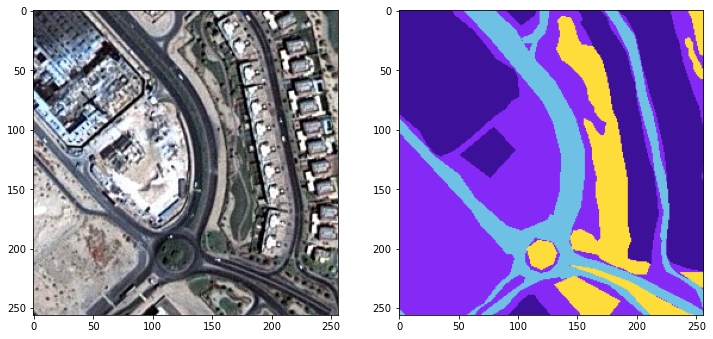

In [17]:
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [18]:
mask_dataset.shape

(1305, 256, 256, 3)

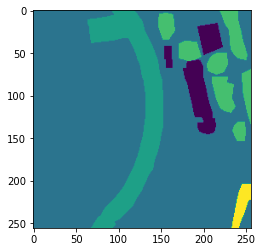

In [19]:
gray_mask=cv2.cvtColor(mask_dataset[0],cv2.COLOR_BGR2GRAY)
plt.imshow(gray_mask)

In [20]:
gray_mask

array([[113, 113, 113, ..., 113, 113, 113],
       [113, 113, 113, ..., 113, 113, 113],
       [113, 113, 113, ..., 113, 113, 113],
       ...,
       [113, 113, 113, ..., 113, 113, 113],
       [113, 113, 113, ..., 113, 113, 113],
       [113, 113, 113, ..., 113, 113, 113]], dtype=uint8)

## Color arrays of classes

In [21]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [22]:
label = single_patch_mask
label.shape

(256, 256, 3)

In [23]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [24]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   

In [25]:
labels.shape

(1305, 256, 256)

In [26]:
labels[0][:5]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [27]:
labels = np.expand_dims(labels, axis=3)


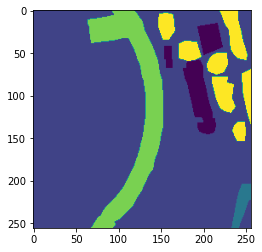

In [28]:
plt.imshow(labels[0])

In [29]:
print("Unique labels in label dataset are: ", np.unique(labels))

NUM_OF_CLASSES=len(np.unique(labels))

id2label={
     0:"Building",
     1:"Land",
     2:"Road",
     3:"Vegatiation",
     4:"Water",
     5:"Unlabeled"
}

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [30]:
id2label[0]

'Building'

In [31]:
labels.shape

(1305, 256, 256, 1)

## Train-Test Splitting

In [32]:
n_classes = len(np.unique(labels))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size = 0.20, random_state = 42)


In [26]:
X_train.shape

(1044, 256, 256, 3)

In [27]:
y_train.shape

(1044, 256, 256, 1)

In [28]:
X_test.shape

(261, 256, 256, 3)

In [29]:
X_test.shape

(261, 256, 256, 3)

In [30]:
n_classes

6

In [31]:
print(len(X_train))
print(len(X_test))

1044
261


In [33]:
y_test[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[5],
        [5],
        [5],
        ...,
        [1],
        [1],
        [1]],

       [[5],
        [5],
        [5],
        ...,
        [1],
        [1],
        [1]],

       [[5],
        [5],
        [5],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

## Custom Dataset Class

In [111]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self,feature_extractor,train=True,transforms=None):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        #self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train=train
        self.transforms=transforms

        #self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        
        self.id2label =id2label #{x[0]:x[1] for x in data}
        
        """"
        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)
        """

    def __len__(self):
        if self.train:
            
            return len(X_train)
        else:
            return len(X_test)

    def __getitem__(self, idx):
        
       
            
        if self.train:
            
            image = X_train[idx]
            #Image.open(os.path.join(self.root_dir, self.images[idx]))
            segmentation_map = y_train[idx]
        else:
            image=X_test[idx]
            segmentation_map=y_test[idx]
            
        

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

## Segformer Feature Extractor

In [112]:

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.size = 256
feature_extractor.do_reduce_labels=False
train_dataset=SemanticSegmentationDataset(feature_extractor)
valid_dataset=SemanticSegmentationDataset(feature_extractor,train=False)

C:\Users\Beytullah\anaconda3\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\Beytullah\anaconda3\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [36]:
encoded_inputs=train_dataset[1]

In [37]:
encoded_inputs["pixel_values"]

tensor([[[ 1.2557,  1.0331,  0.9474,  ..., -1.3130, -1.3302, -1.3302],
         [ 1.1529,  0.9646,  0.7933,  ..., -1.2103, -1.2617, -1.2445],
         [ 1.0673,  0.9132,  0.6049,  ..., -1.1760, -1.2959, -1.2788],
         ...,
         [-0.0287,  0.0741, -0.0116,  ..., -0.7137, -1.9638, -1.9980],
         [-0.0801, -0.1314,  0.0056,  ..., -0.3369, -1.8782, -1.0390],
         [-0.5938, -0.8164, -0.4226,  ..., -0.3027, -1.7240,  0.0912]],

        [[ 1.2381,  1.0105,  0.8704,  ..., -1.0378, -1.0553, -1.0203],
         [ 1.1331,  0.9405,  0.7129,  ..., -0.9328, -0.9853, -0.9678],
         [ 0.9930,  0.8354,  0.5203,  ..., -0.8978, -1.0203, -1.0028],
         ...,
         [ 0.1352,  0.2402,  0.1527,  ..., -0.8627, -2.0357, -2.0357],
         [ 0.0826,  0.0301,  0.1702,  ..., -0.4951, -2.0182, -1.1253],
         [-0.4076, -0.5826, -0.2325,  ..., -0.4601, -1.8782, -0.0049]],

        [[ 1.1585,  0.9319,  0.8099,  ..., -0.9156, -0.9330, -0.8981],
         [ 1.0539,  0.8622,  0.6531,  ..., -0

In [38]:
encoded_inputs["labels"]

tensor([[1, 1, 1,  ..., 3, 3, 3],
        [1, 1, 1,  ..., 3, 3, 3],
        [1, 1, 1,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 1, 1, 1],
        [3, 3, 3,  ..., 1, 1, 1],
        [3, 3, 3,  ..., 1, 1, 1]])

In [39]:
encoded_inputs["labels"].shape

torch.Size([256, 256])

In [40]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 256, 256])

In [41]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1, 3])

In [42]:
mask=encoded_inputs["labels"].numpy()

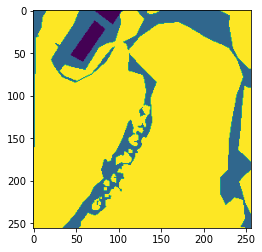

In [43]:
plt.imshow(mask)

In [113]:
label2id = {v:k for k,v in id2label.items()}

In [114]:
label2id

{'Building': 0,
 'Land': 1,
 'Road': 2,
 'Vegatiation': 3,
 'Water': 4,
 'Unlabeled': 5}

In [46]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=4,num_workers=0)

In [47]:
batch = next(iter(train_dataloader))

In [48]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 256, 256])
labels torch.Size([4, 256, 256])


In [49]:
batch["labels"].shape

torch.Size([4, 256, 256])

In [50]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batc

In [120]:
from transformers import AdamW

In [52]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


C:\Users\Beytullah\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [149]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [54]:
labels.shape

(1305, 256, 256, 1)

In [55]:
for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.784922428058025         Train Loss: 0.6711975451401824         Val Pixel-wise accuracy: 0.8710608626856948         Val Loss: 0.36493462696671486
Epoch: 2


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8563149989336386         Train Loss: 0.4282275206512875         Val Pixel-wise accuracy: 0.8759401494806464         Val Loss: 0.33828809518705716
Epoch: 3


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8738866784106726         Train Loss: 0.36220294222863697         Val Pixel-wise accuracy: 0.8767624479351621         Val Loss: 0.33740913399466965
Epoch: 4


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.887455045035059         Train Loss: 0.3218839400058962         Val Pixel-wise accuracy: 0.8824204531582919         Val Loss: 0.32193595588658797
Epoch: 5


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9019865131012781         Train Loss: 0.27451910498155946         Val Pixel-wise accuracy: 0.8899134433630741         Val Loss: 0.31291913591099507
Epoch: 6


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9133247433951075         Train Loss: 0.24196052214423358         Val Pixel-wise accuracy: 0.8911253033262311         Val Loss: 0.30975184708156367
Epoch: 7


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9187033642297504         Train Loss: 0.22713552127053455         Val Pixel-wise accuracy: 0.8901993722626658         Val Loss: 0.3151313638822599
Epoch: 8


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9266247219509549         Train Loss: 0.20058312581074192         Val Pixel-wise accuracy: 0.8926060416481711         Val Loss: 0.3073345667146372
Epoch: 9


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9309399045746902         Train Loss: 0.18698568904765264         Val Pixel-wise accuracy: 0.8919819340561376         Val Loss: 0.3251720060679046
Epoch: 10


  0%|          | 0/261 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9374868458714979         Train Loss: 0.1679365367368149         Val Pixel-wise accuracy: 0.8964101617986505         Val Loss: 0.31716636461064673


In [160]:
image.shape

(1280, 2048, 3)

In [66]:

feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

model

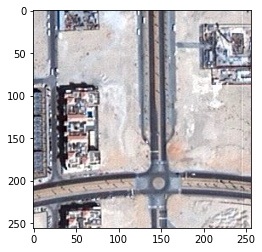

In [67]:
plt.imshow(X_test[0])

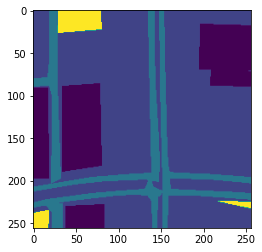

In [68]:
plt.imshow(y_test[0])

In [69]:
X_test[0].shape

(256, 256, 3)

In [142]:
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(X_train[50], return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [143]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 6, 128, 128])


In [144]:
torch.save(model.state_dict(),"C:\\Users\\Beytullah\\Desktop\\segformer_guncel.pt")

In [145]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [146]:
Building

array([ 60,  16, 152])

In [149]:
RGB={
    
    0:Building,
    1:Land,
    2:Road,
    3:Vegetation,
    4:Water,
    5:Unlabeled
    
}

In [150]:
RGB[0]

array([ 60,  16, 152])

In [151]:
for label, color in enumerate(RGB):
    print(RGB[label])

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


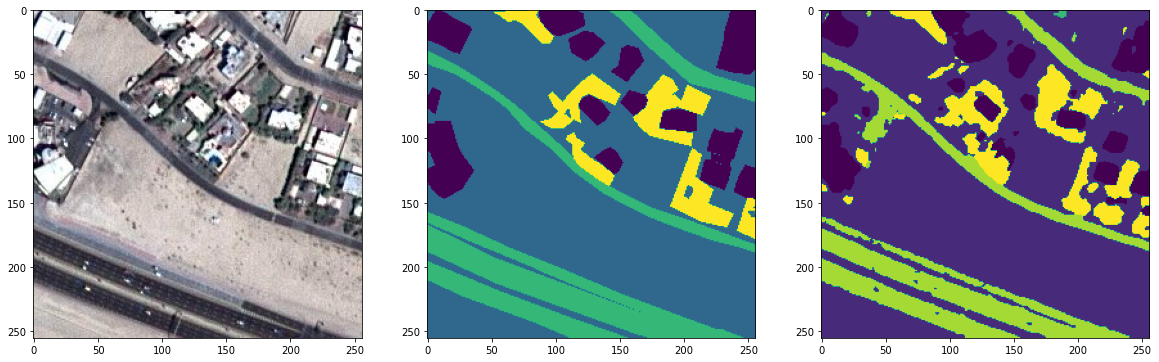

In [152]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=X_train[50].shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(RGB):
    color_seg[seg == label, :] = RGB[label]
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(X_train[50])


fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(y_train[50])
axs[2].imshow(color_seg[:,:,1])
plt.show()

In [153]:
import random

In [154]:
len(X_test)

261

## Inference on Train Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


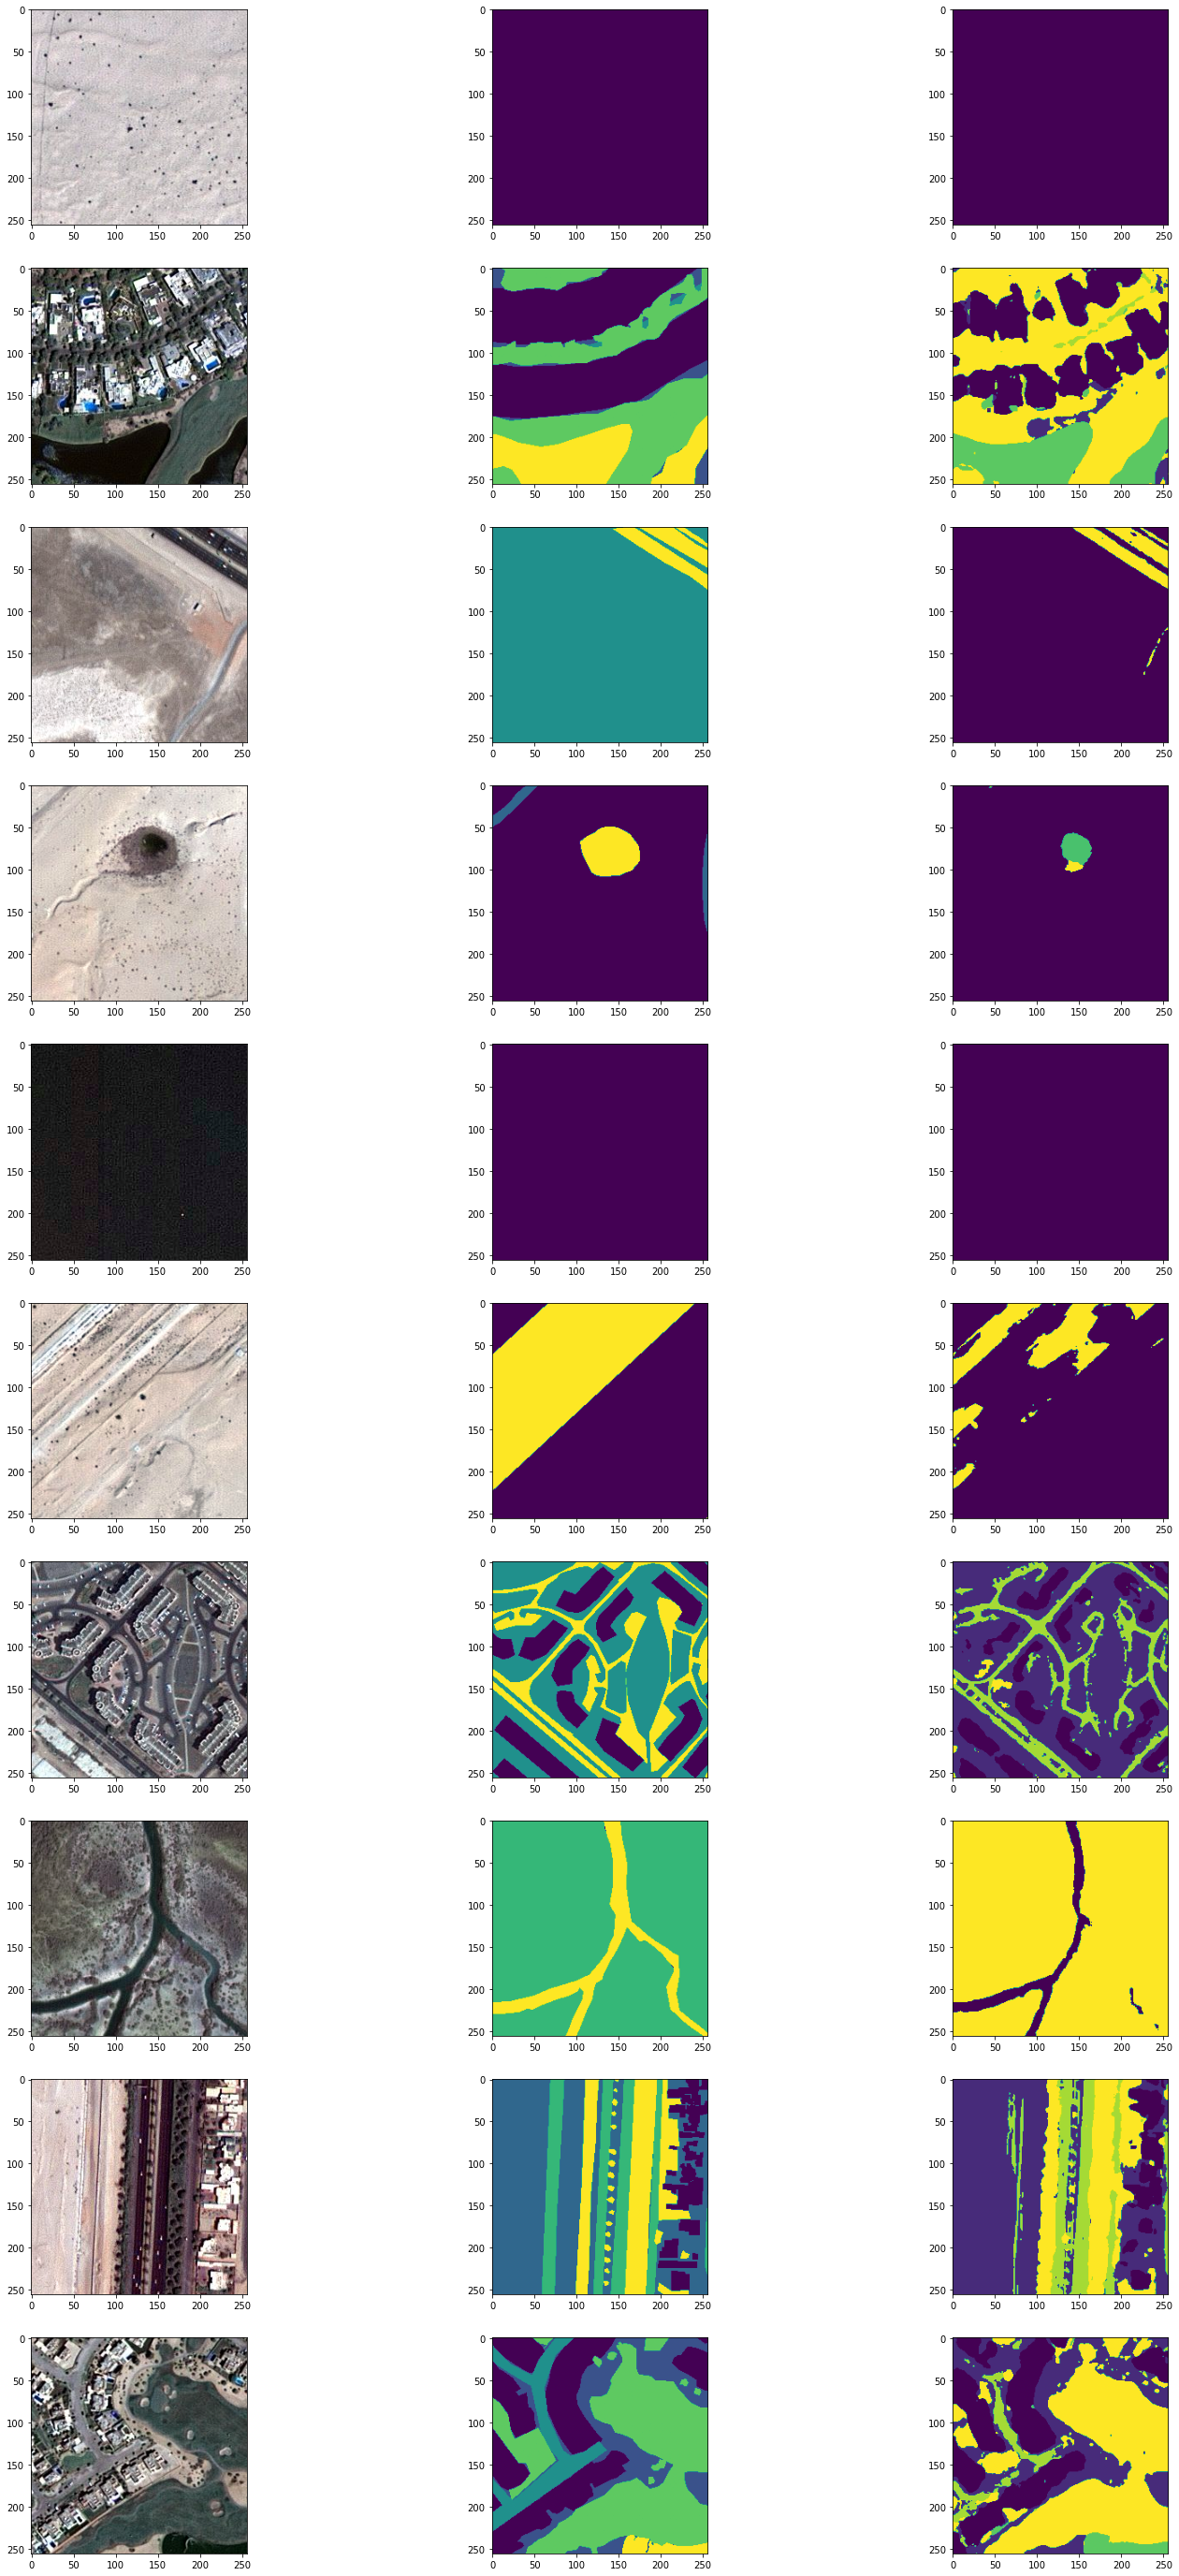

In [157]:
fig,axs=plt.subplots(nrows=10,ncols=3,figsize=(25,50))
for i in range(0,10):
    rand_idx=random.randint(0,len(X_train)-1)
    feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

    pixel_values = feature_extractor_inference(X_train[rand_idx], return_tensors="pt").pixel_values.to(device)
    model.eval()
    outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(logits,
                size=X_train[rand_idx].shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
    for label, color in enumerate(RGB):
        color_seg[seg == label, :] = RGB[label]
# Convert to BGR
    color_seg = color_seg[..., ::-1]

# Show image + mask
    img = np.array(X_train[rand_idx])


    axs[i][0].imshow(img)
    axs[i][1].imshow(y_train[rand_idx])
    axs[i][2].imshow(color_seg[:,:,1])
    

## Inference on Test Dataset

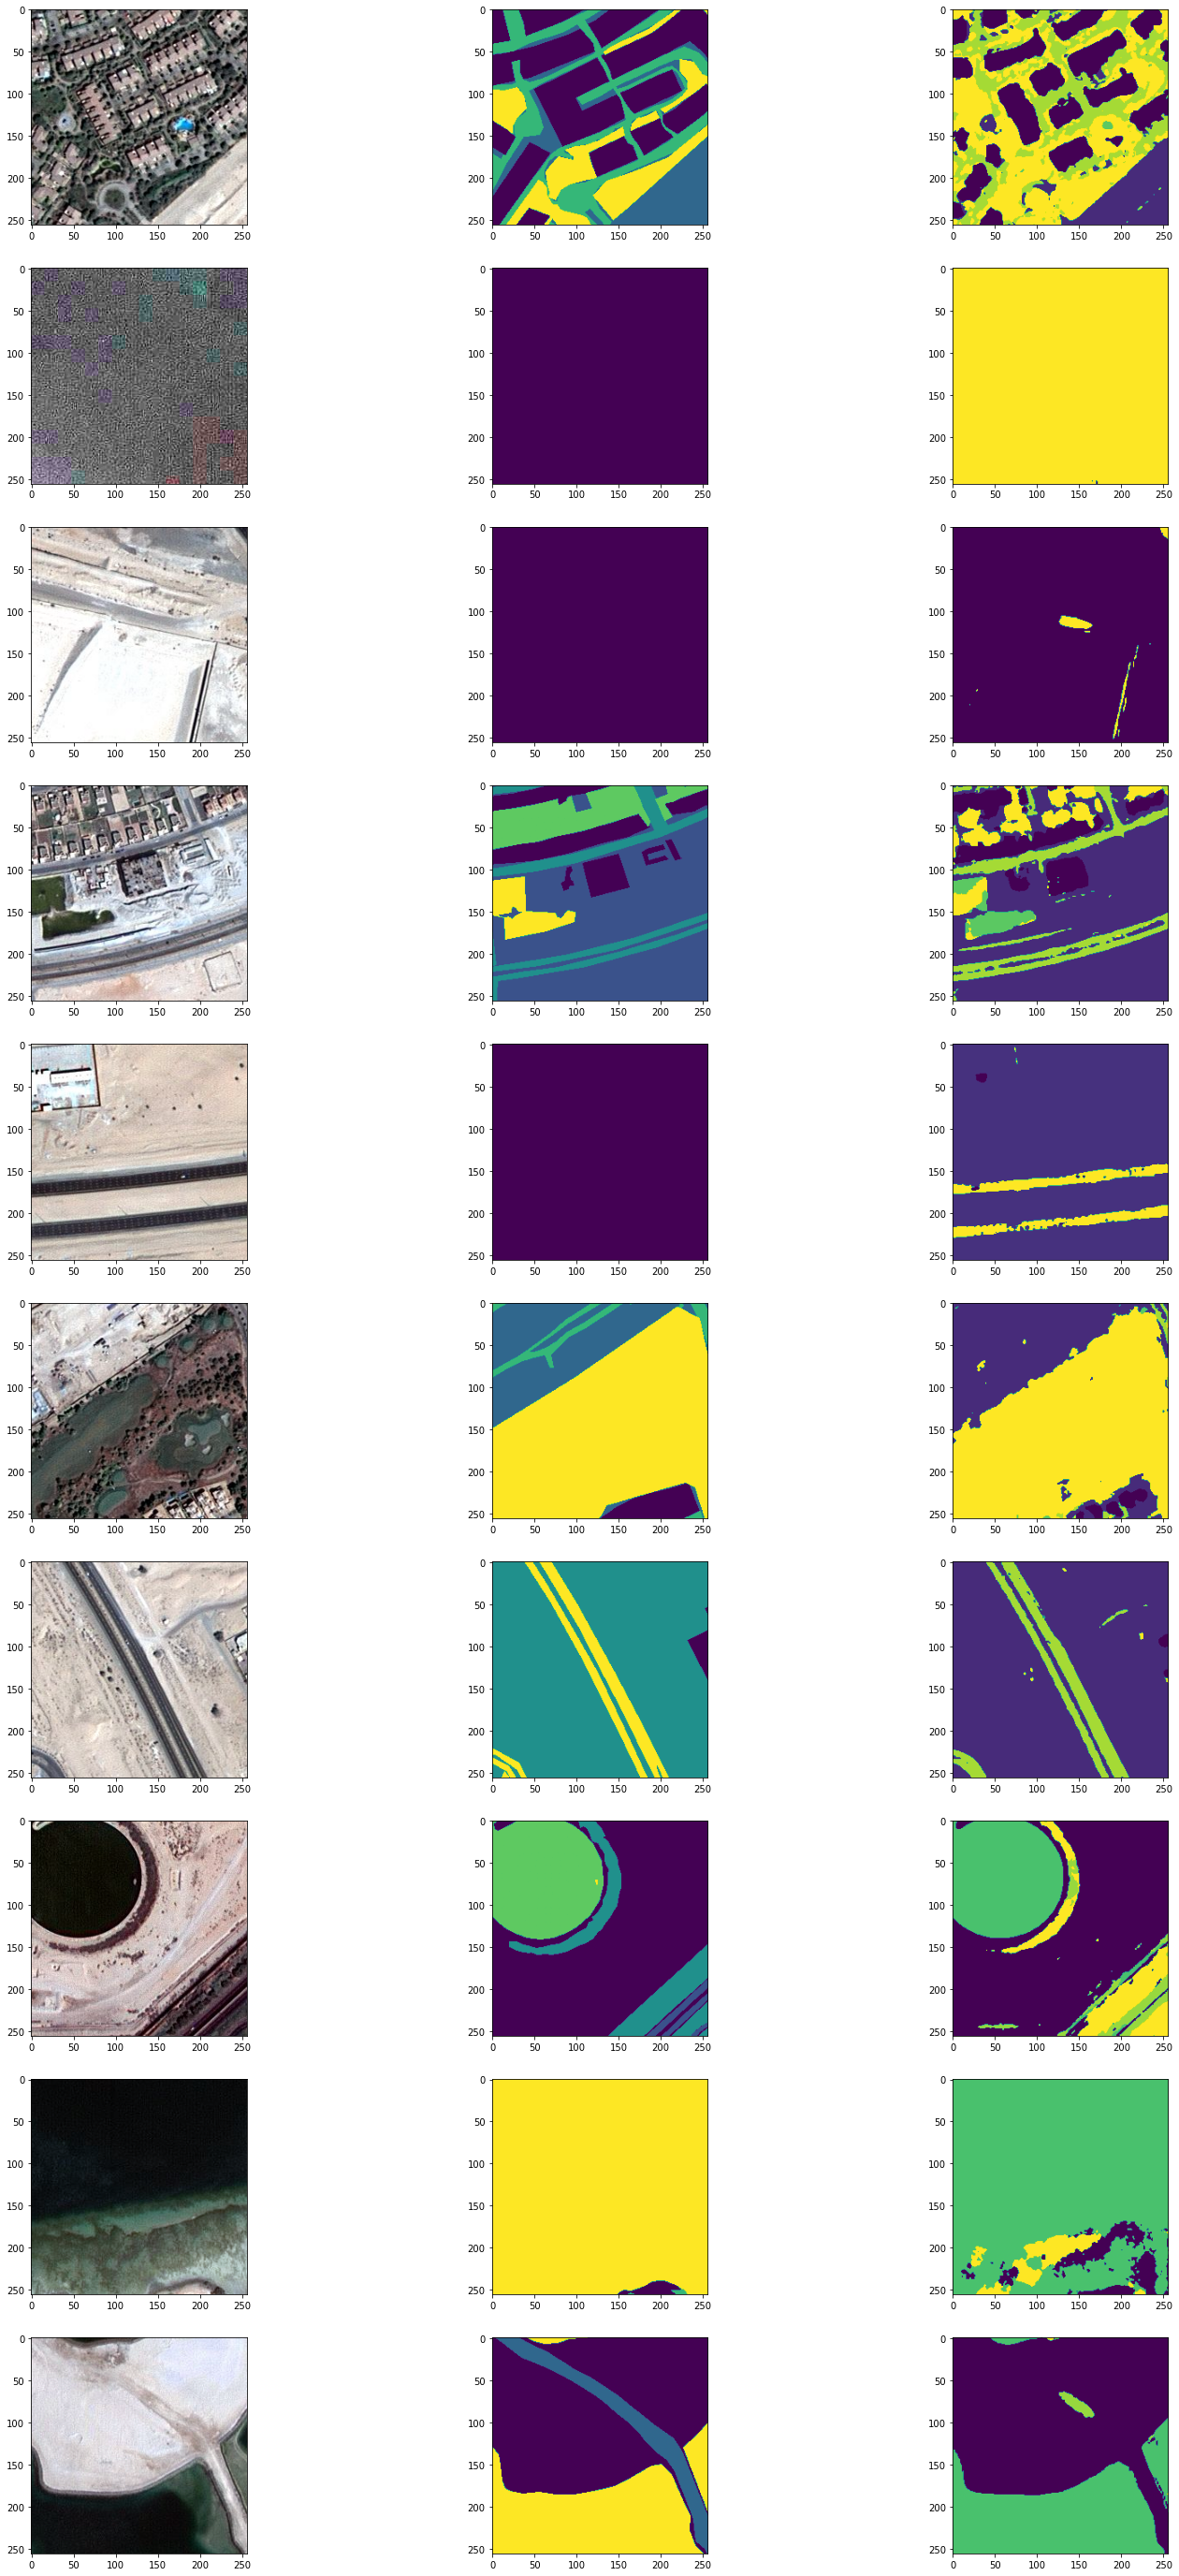

In [155]:
fig,axs=plt.subplots(nrows=10,ncols=3,figsize=(25,50))
for i in range(0,10):
    rand_idx=random.randint(0,len(X_test)-1)
    feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

    pixel_values = feature_extractor_inference(X_test[rand_idx], return_tensors="pt").pixel_values.to(device)
    model.eval()
    outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(logits,
                size=X_test[rand_idx].shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
    for label, color in enumerate(RGB):
        color_seg[seg == label, :] = RGB[label]
# Convert to BGR
    color_seg = color_seg[..., ::-1]

# Show image + mask
    img = np.array(X_test[rand_idx])


    axs[i][0].imshow(img)
    axs[i][1].imshow(y_test[rand_idx])
    axs[i][2].imshow(color_seg[:,:,1])
    
  

    
    

In [124]:
color_seg.shape

(256, 256, 3)

In [127]:
y_test.shape

(261, 256, 256, 1)

In [108]:
model2=torch.load("C:\\Users\\Beytullah\\Desktop\\segformer_guncel.pt")

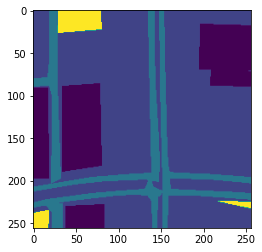

In [123]:
plt.imshow(y_test[0])

## Data Augmentation

In [87]:
pip install -U albumentations --no-binary qudida,albumentations

Skipping wheel build for albumentations, due to binaries being disabled for it.
Skipping wheel build for qudida, due to binaries being disabled for it.
    Running setup.py install for qudida: started
    Running setup.py install for qudida: finished with status 'done'
    Running setup.py install for albumentations: started
    Running setup.py install for albumentations: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [194]:
import albumentations as A


transforms = A.Compose([
    A.HorizontalFlip(p=0.5)
])

In [195]:
transformed=transform(image=X_train,mask=y_train)

In [196]:
transformed["image"].shape

(256, 256, 256, 3)

In [197]:
transformed["mask"].shape

(256, 256, 256, 1)

In [198]:
model2 = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.clas

In [199]:
new_model=torch.load('C:\\Users\\Beytullah\\Desktop\\segformer_guncel.pt')


In [200]:
new_model.fromkeys

<function OrderedDict.fromkeys(iterable, value=None)>

In [201]:
model2.load_state_dict(new_model)

<All keys matched successfully>

In [202]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self,feature_extractor,train=True,transforms=None):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        #self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train=train
        self.transforms=transforms

        #self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        
        self.id2label =id2label #{x[0]:x[1] for x in data}
        
        """"
        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)
        """

    def __len__(self):
        if self.train:
            
            return len(transformed["image"])
        else:
            return len(X_test)

    def __getitem__(self, idx):
        
       
            
        if self.train:
            if self.transforms is not None:
                augmented=self.transforms(image=X_train,mask=y_train)
            
            #Image.open(os.path.join(self.root_dir, self.images[idx]))
            image=augmented["image"][idx]
            segmentation_map = augmented["mask"][idx]
        else:
            image=X_test[idx]
            segmentation_map=y_test[idx]
            
        

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [203]:

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.size = 256
feature_extractor.do_reduce_labels=False
train_dataset=SemanticSegmentationDataset(feature_extractor,transforms=transforms)
valid_dataset=SemanticSegmentationDataset(feature_extractor,train=False)